## Inicialización del Notebook

### Instalar paquetes

In [1]:
# pip install pandas

In [2]:
# pip install matplotlib

In [3]:
# pip install wordcloud

In [4]:
# pip install nltk

In [5]:
# pip install xgboost

In [6]:
# pip install imblearn

### Imports

In [4]:
import pandas as pd
import numpy as np

import random

In [5]:
import string
import spacy
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [6]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

### Variables globales

In [9]:
# URL del archivo de tweets en Github
github_url = 'https://raw.githubusercontent.com/Vialesoft/Vialesoft_Devlab/refs/heads/main/Cursos/DataScienceIII/Proyecto_Final/test2.csv'

## Lectura

In [10]:
# Cargo el archivo en un DataFrame de Pandas
df_tweets = pd.read_csv(github_url)
df_original = df_tweets # Dataframe original de reserva

df_tweets.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


## Análisis y limpieza del DataFrame

### Análisis primario

In [10]:
# Cantidad de filas
df_tweets.count()

textID              3534
text                3534
sentiment           3534
Time of Tweet       3534
Age of User         3534
Country             3534
Population -2020    3534
Land Area (Km�)     3534
Density (P/Km�)     3534
dtype: int64

In [11]:
# Información general del Dataframe
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km�)   3534 non-null   float64
 8   Density (P/Km�)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


In [12]:
# Revisamos valores nulos en las columnas
print(df_tweets.isnull().sum())

# Muchas filas completamente vacías (poco más de un tercio de las que si tienen información)

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km�)     1281
Density (P/Km�)     1281
dtype: int64


In [13]:
# Buscamos tweets duplicados
df_tweets.duplicated().sum()

# Las filas duplicadas son las vacías

np.int64(1280)

In [14]:
# Cantidad de países diferentes

df_tweets["Country"].nunique()
df_tweets.Country.nunique()

195

In [15]:
# Cantidad de sentimientos positivos, negativos y neutros
# Datos extraídos a mano
print("Positivos")
print(df_tweets.loc[df_tweets["sentiment"] == "positive"]["text"].count())
print("Negativos")
print(df_tweets.loc[df_tweets["sentiment"] == "negative"]["text"].count())
print("Neutrales")
print(df_tweets.loc[df_tweets["sentiment"] == "neutral"]["text"].count())

Positivos
1103
Negativos
1001
Neutrales
1430


In [16]:
# Agrupando por sentimiento identificado
df_GroupbySentiment = df_tweets.groupby("sentiment")

print("Cantidad de sentimientos")
print(df_GroupbySentiment.ngroups)

print("Cantidad de tweets clasificados por sentimiento")
print(df_GroupbySentiment.size())

Cantidad de sentimientos
3
Cantidad de tweets clasificados por sentimiento
sentiment
negative    1001
neutral     1430
positive    1103
dtype: int64


In [17]:
df_GroupbySentiment.count()

,textID,text,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km�),Density (P/Km�)
sentiment,,,,,,,,
negative,1001,1001,1001,1001,1001,1001,1001,1001
neutral,1430,1430,1430,1430,1430,1430,1430,1430
positive,1103,1103,1103,1103,1103,1103,1103,1103


In [18]:
def classifyByCountry(dataframe, sentiment):
    df_Country = df_GroupbySentiment.get_group(sentiment).groupby("Country").size().to_frame().reset_index()
    df_Country = df_Country.set_axis(["Country", "Quantity"], axis=1)
    df_Country = df_Country.sort_values("Quantity", ascending=False)

    return df_Country

In [19]:
# Clasificación por país y sentimientos

df_NegativeCountry = classifyByCountry(df_GroupbySentiment, "negative")
df_PositiveCountry = classifyByCountry(df_GroupbySentiment, "positive")
df_NeutralCountry = classifyByCountry(df_GroupbySentiment, "neutral")

print("Negativo")
print(df_NegativeCountry.head())
print("Positivo")
print(df_PositiveCountry.head())
print("Neutral")
print(df_NeutralCountry.head())

Negativo
       Country  Quantity
19      Bhutan        13
114   Mongolia        11
18       Benin        10
99   Lithuania        10
63     Georgia        10
Positivo
                             Country  Quantity
43                     C�te d'Ivoire        12
44  Democratic Republic of the Congo        10
25                      Burkina Faso        10
24                          Bulgaria         9
6                          Argentina         9
Neutral
                        Country  Quantity
62                       Gambia        13
34                        Chile        12
46                      Denmark        12
60                       France        12
56  Eswatini (fmr. "Swaziland")        12


#### Nube de palabras

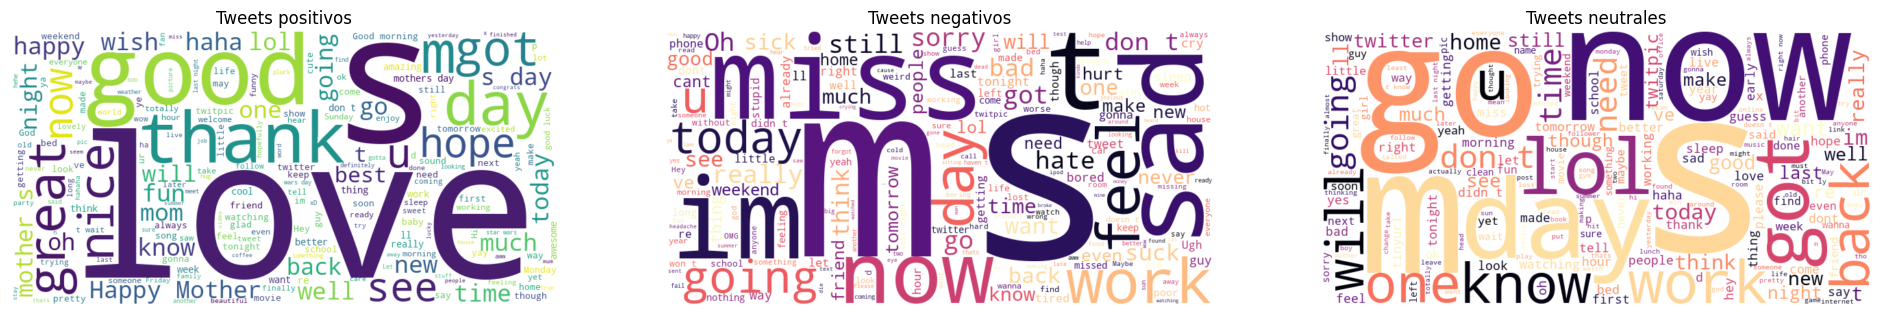

In [20]:
positive_twits = df_tweets[df_tweets['sentiment'] == 'positive']['text'].str.cat(sep=' ')
negative_twits = df_tweets[df_tweets['sentiment'] == 'negative']['text'].str.cat(sep=' ')
neutral_twits = df_tweets[df_tweets['sentiment'] == 'neutral']['text'].str.cat(sep=' ')

# Creando las wordclouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_twits)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(negative_twits)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(neutral_twits)

plt.figure(figsize=(24, 12))

plt.subplot(1,3,1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets positivos', fontsize=12)

plt.subplot(1,3,2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets negativos', fontsize=12)

plt.subplot(1,3,3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tweets neutrales', fontsize=12)

plt.show()

#### Palabras más frecuentes

Como parte del análisis, obtenemos las palabras más frecuentes utilizadas por los twitteros

In [24]:
all_words = [word for sublist in [tweet.split() for tweet in list_tweets] for word in sublist]

# Distribución de frecuencia
fdist = Counter(all_words)

# Las 10 palabras más repetidas
top_10_words = fdist.most_common(10)

print("Las 10 palabras más repetidas:\n", top_10_words)

Las 10 palabras más repetidas:
 [('!', 1340), ('.', 1144), ('I', 931), ('`', 895), (',', 659), ('*', 394), ('...', 289), ('?', 233), ('..', 151), (':', 150)]


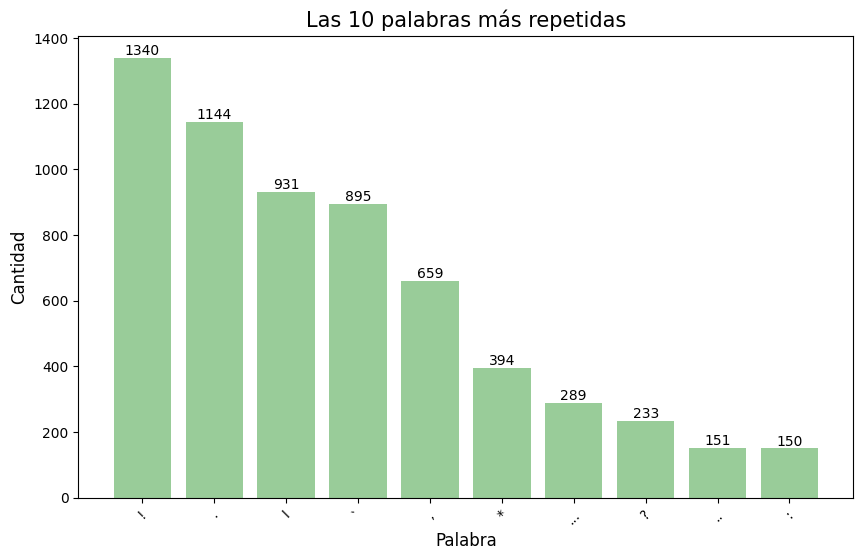

In [25]:
words, frequencies = zip(*top_10_words)

plt.figure(figsize=(10, 6))
bars = plt.bar(words, frequencies, color='Green',alpha=0.4)
plt.xlabel('Palabra', fontsize=12)

plt.xticks(fontsize=10)
plt.ylabel('Cantidad', fontsize=12)

plt.yticks(fontsize=10)
plt.title('Las 10 palabras más repetidas', fontsize=15)
plt.xticks(rotation=45)

for bar, frequency in zip(bars, frequencies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, frequency, ha='center', va='bottom', fontsize=10)

plt.show()

### Limpieza del Dataframe

#### Eliminación de columnas innecesarias

Se eliminarán todas las columnas que no vamos a utilizar

In [11]:
df_tweets = df_tweets[["text", "sentiment", "Time of Tweet", "Country"]]

df_tweets.head()

,text,sentiment,Time of Tweet,Country
0,Last session of the day http://twitpic.com/67ezh,neutral,morning,Afghanistan
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria
3,happy bday!,positive,morning,Andorra
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola


#### Limpieza de valores nulos y duplicados

In [12]:
# Limpiamos valores nulos (y duplicados, al ser los duplicados solamente los nulos)
df_tweets = df_tweets.dropna()

In [13]:
# Chequeamos que no queden ni duplicados ni nulos
print (df_tweets.duplicated().sum())
print (df_tweets.isnull().sum())

0
text             0
sentiment        0
Time of Tweet    0
Country          0
dtype: int64


## Preprocesamiento

- 1: Convertir todo a minúsculas
- 2: Remover caracteres especiales *
- 3: Remover stopwords
- 4: Stemming y lemantización

### Eliminar sentimientos neutros

A modo de prueba, se intentará clasificar solo en negativos y positivos

In [45]:
df_tweets = df_tweets[df_tweets["sentiment"] != "neutral"]

df_tweets.head()

,text,sentiment,Time of Tweet,Country
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria
3,happy bday!,positive,morning,Andorra
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola
5,that`s great!! weee!! visitors!,positive,night,Antigua and Barbuda


### Remover caracteres especiales*

La eliminación de caracteres especiales en este contexto no parece la mejor idea. En un tuit, las personas comparten links, enfatizan emociones a través de signos de exclamación e interrogación, e incluso mediante el uso de numerales al citar hashtags
Por este motivo, se decidió crear una nueva columna removiendo estos caracteres y, luego, generar un set de modelos con cada una de las columnas de texto, a fin de evaluar la precisión de cada uno cuando se remueven (o no) los caracteres especiales

In [46]:
def preprocess(text, special_words = False):
    # Tokenización
    words = nltk.word_tokenize(text)

    if(special_words):
        # Caracteres especiales
        words = [word for word in words if word not in string.punctuation]

    # Stop-Words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Volvemos a juntar y retornamos el texto pre procesado
    return ' '.join(words)

In [47]:
list_tweets = df_tweets["text"].tolist()

In [48]:
list_tweets = [preprocess(tuit) for tuit in list_tweets]

## DeepLearning

### Separación en datos de Train y Test

Primero se vectorizarán los textos y se codificarán los sentimientos

En esta primera instancia, el conjunto de test será de un 30%


In [49]:
df_tweets.head()

,text,sentiment,Time of Tweet,Country
1,Shanghai is also really exciting (precisely -...,positive,noon,Albania
2,"Recession hit Veronique Branquinho, she has to...",negative,night,Algeria
3,happy bday!,positive,morning,Andorra
4,http://twitpic.com/4w75p - I like it!!,positive,noon,Angola
5,that`s great!! weee!! visitors!,positive,night,Antigua and Barbuda


In [50]:
y = df_tweets['sentiment']

In [51]:
X_tweets_text = df_tweets["text"]

In [52]:
# Separo en conjuntos de train y test
# Primero separaremos las X en conjuntos de train y test, para cada conjunto
# En esta primera instancia, el conjunto de test será de un 30%

X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets = train_test_split(X_tweets_text, y, test_size=0.3, random_state=42)

In [53]:
# Vectorización TF-IDF
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',       # quitar palabras comunes
    ngram_range=(1, 2),         # usar bigramas
    max_df=0.9,                 # quitar palabras que aparecen en más del 90% de los textos
    min_df=5                    # quitar palabras muy raras
)

X_train_tweets_vec = vectorizer.fit_transform(X_train_tweets) # aprende el vocabulario y transforma
X_test_tweets_vec = vectorizer.transform(X_test_tweets) # transforma usando el vocabulario ya aprendido

In [54]:
X_train_tweets_vec

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5291 stored elements and shape (1472, 391)>

In [55]:
label_encoder = LabelEncoder()
y_train_tweets = label_encoder.fit_transform(y_train_tweets)
y_test_tweets = label_encoder.transform(y_test_tweets)

### Definimos una función para evaluar cada modelo

#### Evaluación del modelo

In [56]:
def evaluate_model(model, X_val, y_val):
    # model.fit(X_train, y_train) # Esto no es necesario si el modelo ya viene entrenado
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted') # ,  weighted, micro, macro, None
    recall = recall_score(y_val, y_pred, average='weighted') # , average='weighted'
    f1 = f1_score(y_val, y_pred, average='weighted') #, average='weighted'
    confusion = confusion_matrix(y_val, y_pred)
    
    return {
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1, 
        'confusion': confusion
    }

#### Evaluación con calibración

In [58]:
def evaluate_model_calibrated(model, X_val, y_val):
    calibrated_nb = CalibratedClassifierCV(model, cv=5)
    calibrated_nb.fit(X_train_tweets_vec, y_train_tweets)
    y_pred = calibrated_nb.predict(X_test_tweets_vec)
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted') # ,  weighted, micro, macro, None
    recall = recall_score(y_val, y_pred, average='weighted') # , average='weighted'
    f1 = f1_score(y_val, y_pred, average='weighted') #, average='weighted'
    confusion = confusion_matrix(y_val, y_pred)
    
    return {
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1, 
        'confusion': confusion
    }

In [74]:
def train_model(model):
    model_performance = {}
    clf = GridSearchCV(model["model"], model["params"], cv=5, scoring='f1_weighted') #scoring='f1_weighted, accuracy'
    clf.fit(X_train_tweets_vec, y_train_tweets)
    best_model = clf.best_estimator_
    
    metrics = evaluate_model(best_model, X_test_tweets_vec, y_test_tweets)
    model_performance[model["model"]] = metrics

    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1-Score: {metrics['f1']}")
    print(f"Confusion Matrix:\n{confusion}")

    print(f"Mejores parámetros para {model["model"]}_Calibrated: {clf.best_params_}")

    return best_model

### Multinomial NB

#### Definición del modelo

In [71]:
var_model = {
    'model': MultinomialNB(),
    'params': {
        'alpha': [0.01, 0.1, 1, 10],
        'fit_prior': [True, False]
    }
}

#### Entrenamiento del modelo

In [76]:
best_model = train_model(var_model)

Accuracy: 0.7974683544303798
Precision: 0.8004012146726678
Recall: 0.7974683544303798
F1-Score: 0.7977852958240305
Confusion Matrix:
[[239  52]
 [ 76 265]]
Mejores parámetros para MultinomialNB()_Calibrated: {'alpha': 10, 'fit_prior': False}


#### Entrenamiento del modelo calibrado

In [69]:
metrics_Calibrated = evaluate_model_calibrated(MultinomialNB(alpha=10, fit_prior=False), X_test_tweets_vec, y_test_tweets)

print(f"Calibrated Accuracy: {metrics_Calibrated['accuracy']}")
print(f"Calibrated Precision: {metrics_Calibrated['precision']}")
print(f"Calibrated Recall: {metrics_Calibrated['recall']}")
print(f"Calibrated F1-Score: {metrics_Calibrated['f1']}")
print(f"Calibrated Confusion Matrix:\n{confusion}")

Calibrated Accuracy: 0.7974683544303798
Calibrated Precision: 0.8031614157263584
Calibrated Recall: 0.7974683544303798
Calibrated F1-Score: 0.7977240377726481
Calibrated Confusion Matrix:
[[239  52]
 [ 76 265]]


#### Entrenamiento del mejor modelo

In [63]:
best_model.fit(X_train_tweets_vec, y_train_tweets)
y_pred_tweets_cleaned = best_model.predict(X_test_tweets_vec)

In [67]:
accuracy = accuracy_score(y_test_tweets, y_pred_tweets_cleaned)
precision = precision_score(y_test_tweets, y_pred_tweets_cleaned)
recall = recall_score(y_test_tweets, y_pred_tweets_cleaned)
f1 = f1_score(y_test_tweets, y_pred_tweets_cleaned)
confusion = confusion_matrix(y_test_tweets, y_pred_tweets_cleaned)

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1}")
print(f"Confusion Matrix:\n{confusion}")

Test Accuracy: 0.7974683544303798
Test Precision: 0.8359621451104101
Test Recall: 0.7771260997067448
Test F1-Score: 0.8054711246200608
Confusion Matrix:
[[239  52]
 [ 76 265]]


### Logistic Regression

In [ ]:
model = {
    'model': LogisticRegression(),
    'params': {
        'C': [0.01, 0.1, 1],
        'penalty': ['l1', 'l2']
    }
}

### Random Forest Classifier

In [ ]:
model = {
    'model': RandomForestClassifier(),
    'params': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20]
    }
}

### SVC

In [ ]:
model = {
    'model': SVC(),
    'params': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

### K Neighbors Classifier

In [ ]:
model = {
    'model': KNeighborsClassifier(),
    'params': {
        'n_neighbors': [3, 5, 7]
    }
}   

### XGB Classifier

In [ ]:
model = {
    'model': XGBClassifier(),
    'params': {
        'learning_rate': [0.1, 0.01],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200]
    }
}

In [104]:
sample_tweets = ["I'm really happy, my son is five years old!.",
                  "I hate absolutely how the world is going",
                  "I think politics are being bad",
                  "I have gone to the best restaurant ever!!",
                  "I'm just OK",
                  "I think I will come back to Ushuaia next year! #Penguins",
                  "Bus tickets are so expensive! Goverment is really bad!",
                  "I have had the worst dining experience ever. The food was cold and the waiter was rude."]

In [105]:
sample_tweets_preprocessed = [preprocess(tweet) for tweet in sample_tweets]
sample_tweets_vectorized = vectorizer.transform(sample_tweets_preprocessed)
sample_tweets_predictions = best_model.predict(sample_tweets_vectorized)

In [106]:
predicted_labels_formatted = [f"Positive ({prediction})" if prediction == 1 else f"Negative ({prediction})" for prediction in sample_tweets_predictions]

results = dict(zip(sample_tweets, predicted_labels_formatted))

for tweet, prediction in results.items():
    print(f"Tweet: {tweet}\nPrediction: {prediction}\n")

Tweet: I'm really happy, my son is five years old!.
Prediction: Positive (1)

Tweet: I hate absolutely how the world is going
Prediction: Negative (0)

Tweet: I think politics are being bad
Prediction: Negative (0)

Tweet: I have gone to the best restaurant ever!!
Prediction: Positive (1)

Tweet: I'm just OK
Prediction: Positive (1)

Tweet: I think I will come back to Ushuaia next year! #Penguins
Prediction: Positive (1)

Tweet: Bus tickets are so expensive! Goverment is really bad!
Prediction: Negative (0)

Tweet: I have had the worst dining experience ever. The food was cold and the waiter was rude.
Prediction: Negative (0)



La precisión del modelo parece buena, para los ejemplos inventados

Existe sin embargo cierto sesgo hacia el lado positivo (como en el caso de I'm just OK) que debería haberse catalogado quizá como neutral, de existir esta tercera categoría

En las siguientes pruebas, tomaremos 100 tweets random del set y probaremos el modelo con ellos

In [107]:
def get_random_tweets(list_tweets, num_tweets=10):
  random_indices = random.sample(range(len(list_tweets)), num_tweets)
  random_tweets = [list_tweets[i] for i in random_indices]
  return random_tweets

In [108]:
random_tweets = get_random_tweets(list_tweets, 100)

random_tweets_preprocessed = [preprocess(tweet) for tweet in random_tweets]
random_tweets_vectorized = vectorizer.transform(random_tweets_preprocessed)
random_predictions = best_model.predict(random_tweets_vectorized)

In [109]:
random_predicted_labels_formatted = [f"Positive ({prediction})" if prediction == 1 else f"Negative ({prediction})" for prediction in random_predictions]
random_results = dict(zip(random_tweets, random_predicted_labels_formatted))

for tweet, prediction in random_results.items():
    print(f"Tuit: {tweet}\nPrediction: {prediction}\n")

Tuit: _griffiths good atmos . decided stay til closing , funny !
Prediction: Positive (1)

Tuit: watching snl love life hosting
Prediction: Positive (1)

Tuit: tried . failed
Prediction: Negative (0)

Tuit: hour fifteen drive . left , bored ate half food already
Prediction: Negative (0)

Tuit: ` much tune word today . thanks .
Prediction: Positive (1)

Tuit: http : //twitpic.com/4wtii - new hair going greeattt use !
Prediction: Positive (1)

Tuit: http : //twitpic.com/66ymw ` gon na miss guy much thanks making 5 year senior school amazing !
Prediction: Positive (1)

Tuit: study day . finished care plan . hungry hell ! ima go treat burrito , good day work
Prediction: Positive (1)

Tuit: loved , happy birthday ! ! ! said sounded like mixture john lennon , chrissie hynde , janis joplin .
Prediction: Positive (1)

Tuit: radio royal transmitter packed today ... good anyone got spare shed ... lol
Prediction: Negative (0)

Tuit: ` mo nudge , better watch !
Prediction: Negative (0)

Tuit: ` al

La precisión de los tuits elegidos al azar parece buena en términos generales. Sin embargo, tiene algunos errores, propios de un modelo con una precisión de apenas sobre 80%